In [1]:
import io
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

class TClass:
    def __init__(self, name, attrs):
        self.name = name
        # сохраняем в классе атрибуты отсортированными
        self.attrs = sorted(attrs)
        self.attrs_num = len(self.attrs)
        self.obj_num = 1
        ##print("Init: " + self.name + " Attrs = " + str(self.attrs))

classes = []
class_num = 0

def add_new_class(attrs):
    global class_num

    class_num += 1
    new_class_name = "Класс " + str(class_num)
    new_class = TClass(new_class_name, attrs)
    classes.append(new_class)

def get_class_by_attrs(attrs):
    class_name = "_NOT_FOUND_"
    # цикл по всем ранее созданным классам
    for cls in classes:
        # грубое сравнение - по числу атрибутов
        if len(cls.attrs) == len(attrs):
            # предполагаем, что нашли подходящий класс
            class_found = True
            # сравнение по атрибутам
            for idx, attr in enumerate(sorted(attrs)):
                #print(str(idx) + " " + attr + " " + cls.attrs[idx])
                if attr != cls.attrs[idx]:
                    #print("Not equal, not this class...")
                    class_found = False

            if class_found:
                cls.obj_num = cls.obj_num + 1
                #print(cls.name + " - obj_num increased up to " + str(cls.obj_num))
                class_name = cls.name
                break

    return class_name

df_objs_attrs = pd.read_csv('/content/All_objs_attrs256.csv', delimiter=';')
df_objs_attrs = df_objs_attrs.reset_index()

# формируем список ID объектов
objs = df_objs_attrs['OBJ_KEY'].unique()

for obj in objs:
    obj_attrs = df_objs_attrs[df_objs_attrs['OBJ_KEY'].str.fullmatch(obj)] \
     ['TIME_SERIES_KEY'].to_list()
    # Если атрибутов (доп. переменных) нет - то класс не присваиваем
    if len(obj_attrs) > 0:
        # Есть ли класс с таким набором атрибутов?
        obj_class_name = get_class_by_attrs(obj_attrs)
        if obj_class_name == "_NOT_FOUND_":
            # Нет - создать новый класс
            obj_class_name = add_new_class(obj_attrs)

    # Отображаем прогресс
    #print(".", end='')

In [2]:
df_cls = pd.DataFrame.from_records(vars(o) for o in classes)

In [3]:
pd.reset_option('display.max_rows', None)
pd.set_option('display.max_rows', 20)
df_cls

,name,attrs,attrs_num,obj_num
0,Класс 1,"[_CORR, _DZ, _MMAN]",3,18
1,Класс 2,[_DZ],1,5
2,Класс 3,"[_CORR, _MMAN]",2,8
3,Класс 4,"[_CORR, _MMAN, _SPL]",3,1
4,Класс 5,"[_CORR, _MMAN, _SFD]",3,1
5,Класс 6,"[_CORR, _MMAN, _UPL]",3,1
6,Класс 7,"[_CORR, _DZ, _MMAN, _PDZ]",4,24
7,Класс 8,"[_CORR, _DZ, _MMAN, _OVR, _OVR2, _PDZ]",6,1
8,Класс 9,"[_CORR, _DZ, _MMAN, _PDZ, _TRF, _TSR, _TTG]",7,1
9,Класс 10,"[_CORR, _DZ, _M, _MMAN, _PDZ]",5,1


In [4]:
# подсчет количества совпадающих атрибутов у двух классов
def get_num_of_matched_attrs(class_num_1, class_num_2):
  return len(set(df_cls['attrs'][class_num_1]) & set(df_cls['attrs'][class_num_2]))

In [5]:
# ВАРИАНТ 1 - степень "похожести" как отношение числа совпадающих атрибутов
#             к максимальному из количества атрибутов у сравниваемых классов
#             (значения в диапазоне от 0 до 1)
# цикл по всем классам - строим "матрицу похожести"
matrix = []
for i, row in df_cls.iterrows():
    mrow = []
    for j in range(0, i):
        mrow.append(float('nan'))
    for j in range(i, len(df_cls.index)):
        attrs_num_1 = df_cls['attrs_num'][i]
        attrs_num_2 = df_cls['attrs_num'][j]
        attrs_num_max = max(attrs_num_1, attrs_num_2)
        ##print(str(attrs_num_1) + " " + str(attrs_num_2) + " " + str(attrs_num_max) \
        ##      + " " + str(get_num_of_matched_attrs(i, j)/attrs_num_max))
        mrow.append(get_num_of_matched_attrs(i, j)/attrs_num_max)

    matrix.append(mrow)
    ##print(".", end='')

df2 = pd.DataFrame(matrix)

# заполняем "нижнюю часть" матрицы
for i, row in df2.iterrows():
  for j in range(0, i):
    df2.iat[i, j] = df2.iat[j, i]

# формируем "матрицу несходства"
df3 = 1 - df2

In [6]:
# ВАРИАНТ 2 - матрица несходства по разности макс. числа атрибутов и
#             числа совпадающих (возможные значения от 1 до макс. числа атрибутов)
# 1 - то есть 1 несовпадающий атрибут, 0 быть не может, т.к. это был бы один и тот же класс
matrix = []
for i, row in df_cls.iterrows():
    mrow = []
    for j in range(0, i):
        mrow.append(float('nan'))
    for j in range(i, len(df_cls.index)):
        attrs_num_1 = df_cls['attrs_num'][i]
        attrs_num_2 = df_cls['attrs_num'][j]
        attrs_num_max = max(attrs_num_1, attrs_num_2)
        mrow.append(attrs_num_max - get_num_of_matched_attrs(i, j))

    matrix.append(mrow)
    ##print(".", end='')

df2 = pd.DataFrame(matrix)

# заполняем "нижнюю часть" матрицы
for i, row in df2.iterrows():
  for j in range(0, i):
    df2.iat[i, j] = df2.iat[j, i]

df3 = df2

In [7]:
pd.set_option('display.float_format', '{:.2f}'.format)
df3

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00,2.00,1.00,1.00,1.00,1.00,1.00,3.00,4.00,2.00,3.00,1.00,4.00,2
1,2.00,0.00,2.00,3.00,3.00,3.00,3.00,5.00,6.00,4.00,5.00,3.00,6.00,2
2,1.00,2.00,0.00,1.00,1.00,1.00,2.00,4.00,5.00,3.00,4.00,2.00,5.00,1
3,1.00,3.00,1.00,0.00,1.00,1.00,2.00,4.00,5.00,3.00,4.00,2.00,5.00,2
4,1.00,3.00,1.00,1.00,0.00,1.00,2.00,4.00,5.00,3.00,4.00,2.00,5.00,2
5,1.00,3.00,1.00,1.00,1.00,0.00,2.00,4.00,5.00,3.00,4.00,2.00,5.00,2
6,1.00,3.00,2.00,2.00,2.00,2.00,0.00,2.00,3.00,1.00,3.00,1.00,3.00,3
7,3.00,5.00,4.00,4.00,4.00,4.00,2.00,0.00,3.00,2.00,3.00,3.00,3.00,5
8,4.00,6.00,5.00,5.00,5.00,5.00,3.00,3.00,0.00,3.00,4.00,4.00,3.00,6
9,2.00,4.00,3.00,3.00,3.00,3.00,1.00,2.00,3.00,0.00,2.00,1.00,2.00,4


In [8]:
# Формируем condensed distance matrix
# Если передать исходную df3 в функцию linkage, получим сообщение:
# ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix

cond_df3 = squareform(df3)
print(cond_df3.shape)

(91,)


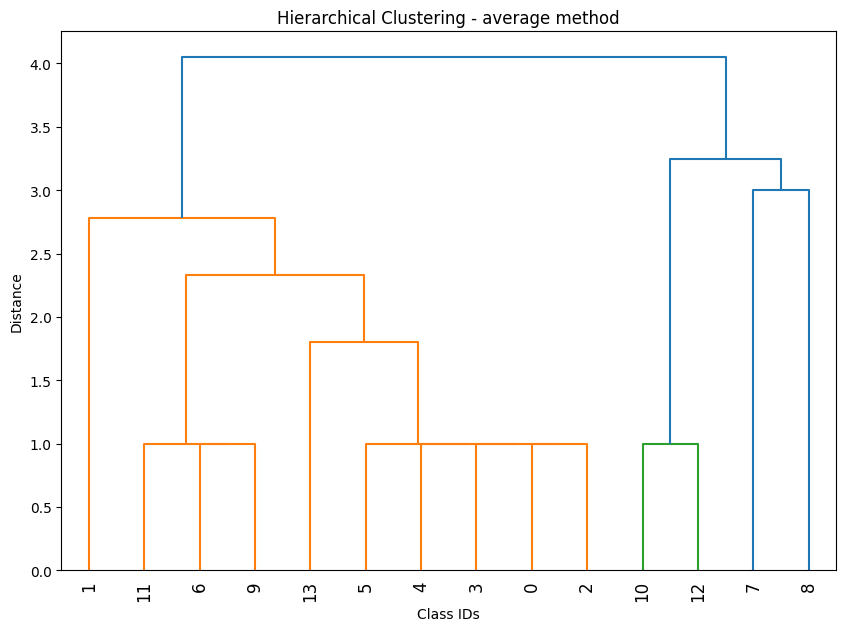

In [10]:
method = 'average'
Z = linkage(cond_df3, method)

# Create a dendrogram
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=df3.index, leaf_rotation=90)
plt.title('Hierarchical Clustering - ' + method + ' method')
plt.xlabel('Class IDs')
plt.ylabel('Distance')

# Show the figure
plt.show()

In [11]:
print(len(Z))

13


In [12]:
Z
# Здесь мы видим матрицу, каждая строка которой - шаг кластеризации
# т.е. кластеризация выполняется всегда попарно
# (это также можно увидеть, запустив ниже 5. Print merge history in chronological order)

array([[ 0.        ,  2.        ,  1.        ,  2.        ],
       [ 3.        , 14.        ,  1.        ,  3.        ],
       [ 4.        , 15.        ,  1.        ,  4.        ],
       [ 5.        , 16.        ,  1.        ,  5.        ],
       [ 6.        ,  9.        ,  1.        ,  2.        ],
       [11.        , 18.        ,  1.        ,  3.        ],
       [10.        , 12.        ,  1.        ,  2.        ],
       [13.        , 17.        ,  1.8       ,  6.        ],
       [19.        , 21.        ,  2.33333333,  9.        ],
       [ 1.        , 22.        ,  2.77777778, 10.        ],
       [ 7.        ,  8.        ,  3.        ,  2.        ],
       [20.        , 24.        ,  3.25      ,  4.        ],
       [23.        , 25.        ,  4.05      , 14.        ]])

In [13]:
# 5. Print merge history in chronological order
print("\nMerge history (from first to last merge):")
for i, (idx1, idx2, dist, size) in enumerate(Z):
    print(f"Step {i+1}: Merged cluster {idx1} and {idx2} (distance={dist:.2f}) forming new cluster {len(Z)+i} with {size} elements")


Merge history (from first to last merge):
Step 1: Merged cluster 0.0 and 2.0 (distance=1.00) forming new cluster 13 with 2.0 elements
Step 2: Merged cluster 3.0 and 14.0 (distance=1.00) forming new cluster 14 with 3.0 elements
Step 3: Merged cluster 4.0 and 15.0 (distance=1.00) forming new cluster 15 with 4.0 elements
Step 4: Merged cluster 5.0 and 16.0 (distance=1.00) forming new cluster 16 with 5.0 elements
Step 5: Merged cluster 6.0 and 9.0 (distance=1.00) forming new cluster 17 with 2.0 elements
Step 6: Merged cluster 11.0 and 18.0 (distance=1.00) forming new cluster 18 with 3.0 elements
Step 7: Merged cluster 10.0 and 12.0 (distance=1.00) forming new cluster 19 with 2.0 elements
Step 8: Merged cluster 13.0 and 17.0 (distance=1.80) forming new cluster 20 with 6.0 elements
Step 9: Merged cluster 19.0 and 21.0 (distance=2.33) forming new cluster 21 with 9.0 elements
Step 10: Merged cluster 1.0 and 22.0 (distance=2.78) forming new cluster 22 with 10.0 elements
Step 11: Merged cluster

In [14]:
# функция формирует множество атрибутов, совпадающих у двух исходных классов или кластеров (т.е. вводимых базовых классов)
def get_matched_attrs(attrs1, attrs2):
    return sorted(list(set(attrs1) & set(attrs2)))

In [15]:
# Вся информация о взаимосвязях и последовательности выделения кластеров хранится
# в матрице связи (linkage matrix), для которой принято имя Z.
# На её основе, можно сформировать древовидную структуру, дополнив каждый элемент дерева (класс) информацией о его атрибутах

Z_attrs = []

def build_cluster_tree(Z, element_names=None):
    """Recursively builds the cluster hierarchy tree"""
    if element_names is None:
        element_names = [str(i) for i in range(len(Z)+1)]

    clusters = {}
    global Z_attrs

    for i, (idx1, idx2, dist, size) in enumerate(Z):
        # Get original elements for left cluster
        if idx1 < len(element_names):
            left = {'type': 'leaf', 'id': int(idx1), 'name': element_names[int(idx1)], 'attrs': df_cls['attrs'][int(idx1)]}
        else:
            left = clusters[idx1]

        # Get original elements for right cluster
        if idx2 < len(element_names):
            right = {'type': 'leaf', 'id': int(idx2), 'name': element_names[int(idx2)], 'attrs': df_cls['attrs'][int(idx2)]}
        else:
            right = clusters[idx2]

        # определяем перечень совпадающих атрибутов
        attrs = get_matched_attrs(left['attrs'], right['attrs'])

        # сохраним атрибуты еще и в массиве, чтобы в будущем в дереве не искать
        Z_attrs.append(attrs)

        # Create new cluster
        new_cluster = {
            'type': 'cluster',
            'id': len(element_names) + i,
            'left': left,
            'right': right,
            'distance': dist,
            'size': size,
            'attrs': attrs
        }
        clusters[len(element_names) + i] = new_cluster

    # The last cluster is the root containing everything
    return clusters[len(element_names) + len(Z) - 1]

In [16]:
# 3. Printing the Complete Hierarchy
def print_cluster_tree(node, indent=0):
    """Prints the cluster hierarchy in readable format"""
    if node['type'] == 'leaf':
        print('  ' * indent + f"Element {node['id']}: attrs={df_cls['attrs'][int(node['name'])]}")
    else:
        print('  ' * indent + f"Cluster {node['id']} (distance={node['distance']:.2f}, size={node['size']}, attrs={node['attrs']}):")
        print_cluster_tree(node['left'], indent+1)
        print_cluster_tree(node['right'], indent+1)

# Build and print the complete hierarchy
root_cluster = build_cluster_tree(Z)
print_cluster_tree(root_cluster)

Cluster 26 (distance=4.05, size=14.0, attrs=[]):
  Cluster 23 (distance=2.78, size=10.0, attrs=[]):
    Element 1: attrs=['_DZ']
    Cluster 22 (distance=2.33, size=9.0, attrs=['_CORR']):
      Cluster 19 (distance=1.00, size=3.0, attrs=['_CORR', '_DZ', '_MMAN']):
        Element 11: attrs=['_CORR', '_DZ', '_M', '_MMAN']
        Cluster 18 (distance=1.00, size=2.0, attrs=['_CORR', '_DZ', '_MMAN', '_PDZ']):
          Element 6: attrs=['_CORR', '_DZ', '_MMAN', '_PDZ']
          Element 9: attrs=['_CORR', '_DZ', '_M', '_MMAN', '_PDZ']
      Cluster 21 (distance=1.80, size=6.0, attrs=['_CORR']):
        Element 13: attrs=['_CORR', '_CORRD']
        Cluster 17 (distance=1.00, size=5.0, attrs=['_CORR', '_MMAN']):
          Element 5: attrs=['_CORR', '_MMAN', '_UPL']
          Cluster 16 (distance=1.00, size=4.0, attrs=['_CORR', '_MMAN']):
            Element 4: attrs=['_CORR', '_MMAN', '_SFD']
            Cluster 15 (distance=1.00, size=3.0, attrs=['_CORR', '_MMAN']):
              Element 3

In [17]:
Z_attrs

[['_CORR', '_MMAN'],
 ['_CORR', '_MMAN'],
 ['_CORR', '_MMAN'],
 ['_CORR', '_MMAN'],
 ['_CORR', '_DZ', '_MMAN', '_PDZ'],
 ['_CORR', '_DZ', '_MMAN'],
 ['_CORR', '_DZ', '_M', '_MMAN', '_YPL', '_YPLPC'],
 ['_CORR'],
 ['_CORR'],
 [],
 ['_CORR', '_DZ', '_MMAN', '_PDZ'],
 ['_CORR', '_DZ', '_MMAN'],
 []]

In [18]:
# Выше мы видим бинарное дерево.
# Его листья - исходные элементы (выделенные при анализе массива объктов классы).
# Узлы - полученные кластеры (предлагаемые базовые классы).
# Листья имеют исходный перечень (множество) атрибутов, выделенных при анализе.
# Для каждого узла мы при построеннии этого дерева задали перечень атрибутов как пересечение множеств атрибутов группируемых им элементов.
# Для того, чтобы данное дерево стало похоже на "обычную" иерархию классов, нам необходимо выполнить его дальнейшее преобразование:
# 1) Уйти от бинарности - если несколько последовательных шагов кластеризации было с одинаковым значением distance и прирастанием size по единице,
#    то оставляем только кластер с наибольшим size, и включаем в него непосредственно исходные элементы, обработанные на данных шагах.
#    На дендрограмме такая ситуация видна как несколько (больше 2-х) элементов под общей горизонтальной линией.
#    Соответственно, шаги:
#    1.1 - Сделать дерево не бинарным - перейти от left, right к children
#    1.2 - В цикле по строкам Z, в последовательностях кластеров с одинаковыми distance и наборами атрибутов, и прирастанием size по единице,
#          переносим все элементы непосредственно в наивысший кластер последовательности, а вложенные кластеры - удаляем
# 2) Удалить элементы, перечень атрибутов которых совпадает с перечнем атрибутов группирующего их элемента (базового класса).
#    (Такая ситуация возможна, когда у одного из двух классов, объединяемых в кластер на некотором шаге алгоритма кластеризации,
#     перечень атрибутов является подмножеством перечня атрибутов второго класса).
# И для того, чтобы явно выделить добавляемые в производном классе атрибуты:
# 3) Явно выделим список доп. переменных, добавляемых в производном классе по сравнению с базовым (добавим атрибут attrs_added)

In [19]:
# Шаг 1.1
import numpy as np
from collections import defaultdict

def create_non_binary_tree(Z, elements=None):
    """
    Transforms binary dendrogram into non-binary tree while preserving original structure.
    Groups nodes merged at the same distance level under common parents.

    Args:
        Z: linkage matrix (n-1 x 4) from scipy.cluster.hierarchy.linkage
        elements: optional list of original element names/IDs

    Returns:
        Dictionary representing the non-binary tree hierarchy
    """
    n = Z.shape[0] + 1
    if elements is None:
        elements = [str(i) for i in range(n)]

    # Create all leaf nodes
    nodes = {i: {'id': i, 'name': elements[i], 'type': 'leaf', 'attrs': df_cls['attrs'][i]} for i in range(n)}

    # Track merge operations by distance
    merge_groups = defaultdict(list)
    for i in range(Z.shape[0]):
        merge_groups[Z[i, 2]].append((i + n, Z[i, 0], Z[i, 1], Z[i, 3]))

    # Process merges in order of increasing distance
    for distance in sorted(merge_groups.keys()):
        merges = merge_groups[distance]

        # Group all merges at this distance level
        for merge_id, left_id, right_id, size in merges:
            # Get left and right children (could be leaves or clusters)
            left = nodes[left_id]
            right = nodes[right_id]

            attrs = get_matched_attrs(left['attrs'], right['attrs'])

            # Create new cluster node with all children at this distance
            nodes[merge_id] = {
                'id': merge_id,
                'type': 'cluster',
                'distance': distance,
                'size': size,
                'attrs': attrs,
                'children': [left, right]  # Maintains original structure
            }

            # Remove child references (they're now part of this cluster)
            nodes.pop(left_id, None)
            nodes.pop(right_id, None)

    # The root is the last cluster created
    root_id = 2 * n - 2
    return nodes[root_id]

def print_tree(node, indent=0, last=True, prefix=''):
    """
    Pretty-prints the non-binary tree structure with proper indentation

    Args:
        node: current node to print
        indent: current indentation level
        last: whether this is the last child of its parent
        prefix: prefix string for the current line
    """
    if indent == 0:
        current_prefix = ''
    else:
        current_prefix = prefix + ('└── ' if last else '├── ')

    if node['type'] == 'leaf':
        print(f"{current_prefix}Element {node['id']}: {df_cls['attrs'][int(node['name'])]}")
    else:
        print(f"{current_prefix}Cluster {node['id']} (distance={node['distance']:.2f}, size={node['size']}, attrs={node['attrs']})")
        new_prefix = prefix + ('    ' if last else '│   ')

        # Print all children
        children = node['children']
        for i, child in enumerate(children):
            print_tree(child, indent + 1, i == len(children) - 1, new_prefix)

# Создаем небинарное дерево, выводим на печать
tree = create_non_binary_tree(Z)
print("Non-binary Tree Structure:")
print_tree(tree)

Non-binary Tree Structure:
Cluster 26 (distance=4.05, size=14.0, attrs=[])
    ├── Cluster 23 (distance=2.78, size=10.0, attrs=[])
    │   ├── Element 1: ['_DZ']
    │   └── Cluster 22 (distance=2.33, size=9.0, attrs=['_CORR'])
    │       ├── Cluster 19 (distance=1.00, size=3.0, attrs=['_CORR', '_DZ', '_MMAN'])
    │       │   ├── Element 11: ['_CORR', '_DZ', '_M', '_MMAN']
    │       │   └── Cluster 18 (distance=1.00, size=2.0, attrs=['_CORR', '_DZ', '_MMAN', '_PDZ'])
    │       │       ├── Element 6: ['_CORR', '_DZ', '_MMAN', '_PDZ']
    │       │       └── Element 9: ['_CORR', '_DZ', '_M', '_MMAN', '_PDZ']
    │       └── Cluster 21 (distance=1.80, size=6.0, attrs=['_CORR'])
    │           ├── Element 13: ['_CORR', '_CORRD']
    │           └── Cluster 17 (distance=1.00, size=5.0, attrs=['_CORR', '_MMAN'])
    │               ├── Element 5: ['_CORR', '_MMAN', '_UPL']
    │               └── Cluster 16 (distance=1.00, size=4.0, attrs=['_CORR', '_MMAN'])
    │                   ├─

In [20]:
def move_element(tree, element_id, target_cluster_id):
    """
    Moves a leaf element to another cluster in the non-binary tree.

    Args:
        tree: The non-binary tree structure
        element_id: ID of the leaf element to move
        target_cluster_id: ID of the destination cluster

    Returns:
        Modified tree with the element moved
    """
    # First find and remove the element from its current position
    def find_and_remove(node, element_id):
        if node['type'] == 'cluster':
            for i, child in enumerate(node['children']):
                if child['id'] == element_id and child['type'] == 'leaf':
                    # Found the element - remove it
                    node['children'].pop(i)
                    return True
                elif find_and_remove(child, element_id):
                    return True
        return False

    # Then find the target cluster and add the element
    def find_and_add(node, target_id, element):
        if node['id'] == target_id and node['type'] == 'cluster':
            node['children'].append(element)
            node['size'] += 1  # Update cluster size
            return True
        elif node['type'] == 'cluster':
            for child in node['children']:
                if find_and_add(child, target_id, element):
                    return True
        return False

    # Create a copy of the element to move
    element_copy = None

    # First find the element in the tree
    def find_element(node, element_id):
        nonlocal element_copy
        if node['id'] == element_id and node['type'] == 'leaf':
            element_copy = node.copy()
            return True
        elif node['type'] == 'cluster':
            for child in node['children']:
                if find_element(child, element_id):
                    return True
        return False

    if not find_element(tree, element_id):
        raise ValueError(f"Element {element_id} not found in tree")

    # Remove the element from its current location
    if not find_and_remove(tree, element_id):
        raise ValueError(f"Could not remove element {element_id} from its current location")

    # Add to target cluster
    if not find_and_add(tree, target_cluster_id, element_copy):
        raise ValueError(f"Target cluster {target_cluster_id} not found")

    # Update all parent cluster sizes along the path
    def update_cluster_sizes(node):
        if node['type'] == 'cluster':
            node['size'] = sum(child['size'] if child['type'] == 'cluster' else 1
                            for child in node['children'])
            for child in node['children']:
                if child['type'] == 'cluster':
                    update_cluster_sizes(child)

    update_cluster_sizes(tree)
    return tree

In [21]:
# Шаг 1.2
# В цикле по строкам Z, определяем последовательность с одинаковым значением distance и прирастанием size по единице
# Формируем список элементов для перемещения и, когда последовательность заканчивается:
# - перемещаем их непосредственно в top-most кластер последовательности
# - удаляем из дерева ставшие ненужными "вложенные" кластеры

def rearrange_tree(tree):
    n = Z.shape[0]
    merge_seq = False
    elements_to_move = []

    for i in range(n):
        ##print(f"i = {i}, cluster attrs = {Z_attrs[i]}")
        if i >= 1:
            # если distance не изменился и size увеличился на 1
            # и также - если есть совпадение attrs у этих кластеров!
            if Z[i, 2] == Z[i-1, 2] and Z[i, 3] - Z[i-1, 3] == 1 and \
               Z_attrs[i] == Z_attrs[i-1]:
                # добавляем элементы в список перемещаемых
                # если это начальный шаг, то оба элемента перемещаем, иначе только один
                ##print(f"Row = {i}: Will move element {Z[i-1, 0]}")
                elements_to_move.append(Z[i-1, 0])
                if not merge_seq:
                    ##print(f"Row = {i}: Will move element {Z[i-1, 1]}")
                    elements_to_move.append(Z[i-1, 1])
                # попали в последовательность
                merge_seq = True
            else:
                # изменения уже не те, но на предыдущем шаге мы были в последовательности
                # (т.е. вышли из последовательности)
                if merge_seq:
                    # перемещаем элементы в целевой кластер
                    target_cluster_id = i + n
                    m = len(elements_to_move)
                    for _ in range(m):
                        element_id = elements_to_move.pop()
                        ##print(f"Moving element {element_id} to target cluster {target_cluster_id}")
                        tree = move_element(tree, element_id, target_cluster_id)
                    merge_seq = False
    return tree

def remove_empty_clusters(tree):
    def _clean(node):
        if node['type'] == 'leaf':
            return True  # Keep all leaves

        # Process children first (post-order traversal)
        kept_children = []
        for child in node['children']:
            if _clean(child):
                kept_children.append(child)

        # Update the node's children
        node['children'] = kept_children

        # Keep cluster if it has any children left
        if kept_children:
            # Update cluster size
            node['size'] = sum(child['size'] if child['type'] == 'cluster' else 1
                             for child in kept_children)
            return True
        return False  # Remove empty cluster

    # Start cleaning from root
    _clean(tree)

    # Handle case where root becomes empty (shouldn't happen with proper trees)
    if tree['type'] == 'cluster' and not tree['children']:
        raise ValueError("Root cluster became empty - invalid tree structure")

    return tree

tree = create_non_binary_tree(Z)
tree = rearrange_tree(tree)
print("\nTree - non-binary & re-arranged:")
print_tree(tree)
tree = remove_empty_clusters(tree)
print("\nTree - after removing empty clusters:")
print_tree(tree)


Tree - non-binary & re-arranged:
Cluster 26 (distance=4.05, size=15.0, attrs=[])
    ├── Cluster 23 (distance=2.78, size=12.0, attrs=[])
    │   ├── Element 1: ['_DZ']
    │   └── Cluster 22 (distance=2.33, size=11.0, attrs=['_CORR'])
    │       ├── Cluster 19 (distance=1.00, size=3, attrs=['_CORR', '_DZ', '_MMAN'])
    │       │   ├── Element 11: ['_CORR', '_DZ', '_M', '_MMAN']
    │       │   └── Cluster 18 (distance=1.00, size=2, attrs=['_CORR', '_DZ', '_MMAN', '_PDZ'])
    │       │       ├── Element 6: ['_CORR', '_DZ', '_MMAN', '_PDZ']
    │       │       └── Element 9: ['_CORR', '_DZ', '_M', '_MMAN', '_PDZ']
    │       └── Cluster 21 (distance=1.80, size=9.0, attrs=['_CORR'])
    │           ├── Element 13: ['_CORR', '_CORRD']
    │           └── Cluster 17 (distance=1.00, size=7, attrs=['_CORR', '_MMAN'])
    │               ├── Element 5: ['_CORR', '_MMAN', '_UPL']
    │               ├── Cluster 16 (distance=1.00, size=2, attrs=['_CORR', '_MMAN'])
    │               │   └─

In [22]:
# Удалить элементы, перечень атрибутов которых совпадает с перечнем атрибутов группирующего их элемента (базового класса)
# Эта задача также имеет два варианта:
# 1) Если группирующий объект (кластер) содержит только группируемый элемент-"лист" с таким же набором атрибутов... но такого не может быть у нас.
#    Поэтому "удалять кластер и перемещать на его место элемент" - нет необходимости.
# 2) Если группирующий объект (кластер) содержит несколько элементов-"листьев", и один из них содержит такой же набор атрибутов -
#    нам необходимо просто удалить этот лист.

def prune_leaves_with_parent_attr(tree, attr_key='attrs'):
    """
    Prunes leaf elements that have the same attribute value as their parent cluster.

    Args:
        tree: The non-binary tree structure (modified in-place)
        attr_key: The key of the attribute to compare (default 'attr')

    Returns:
        The pruned tree structure
    """
    def _prune(node, parent_attr=None):
        if node['type'] == 'leaf':
            # Skip if no attribute to compare
            if attr_key not in node or parent_attr is None:
                return True

            ##print(f"Leaf attrs {node[attr_key]}, parent attrs {parent_attr}")
            # Remove leaf if attribute matches parent's
            if node[attr_key] == parent_attr:
                return False
            return True

        # For clusters, get their attribute if exists
        cluster_attr = node.get(attr_key)

        # Process children first
        kept_children = []
        for child in node['children']:
            if _prune(child, cluster_attr):
                kept_children.append(child)
            else:
                print(f"Pruning1 element {child['id']} with attrs {child[attr_key]}")

        # Update the node's children
        node['children'] = kept_children

        # Update cluster size
        if kept_children:
            node['size'] = sum(child['size'] if child['type'] == 'cluster' else 1
                             for child in kept_children)
            return True

        print(f"Pruning2 element {node['id']} with attrs {node[attr_key]}")
        return False  # Remove empty cluster

    # Start pruning from root (with no parent attribute)
    _prune(tree)

    # Handle case where root becomes empty
    if tree['type'] == 'cluster' and not tree['children']:
        raise ValueError("Root cluster became empty after pruning")

    return tree

In [23]:
tree = prune_leaves_with_parent_attr(tree)
print("\n")
print_tree(tree)

Pruning1 element 6 with attrs ['_CORR', '_DZ', '_MMAN', '_PDZ']
Pruning1 element 2 with attrs ['_CORR', '_MMAN']
Pruning1 element 10 with attrs ['_CORR', '_DZ', '_M', '_MMAN', '_YPL', '_YPLPC']


Cluster 26 (distance=4.05, size=11, attrs=[])
    ├── Cluster 23 (distance=2.78, size=8, attrs=[])
    │   ├── Element 1: ['_DZ']
    │   └── Cluster 22 (distance=2.33, size=7, attrs=['_CORR'])
    │       ├── Cluster 19 (distance=1.00, size=2, attrs=['_CORR', '_DZ', '_MMAN'])
    │       │   ├── Element 11: ['_CORR', '_DZ', '_M', '_MMAN']
    │       │   └── Cluster 18 (distance=1.00, size=1, attrs=['_CORR', '_DZ', '_MMAN', '_PDZ'])
    │       │       └── Element 9: ['_CORR', '_DZ', '_M', '_MMAN', '_PDZ']
    │       └── Cluster 21 (distance=1.80, size=5, attrs=['_CORR'])
    │           ├── Element 13: ['_CORR', '_CORRD']
    │           └── Cluster 17 (distance=1.00, size=4, attrs=['_CORR', '_MMAN'])
    │               ├── Element 5: ['_CORR', '_MMAN', '_UPL']
    │               ├── Elem

In [25]:
# 3) Явно выделим список доп. переменных, добавляемых в производном классе по сравнению с базовым (добавим атрибут attrs_added)

def add_attrs_added(tree, attr_key='attrs'):

    # формирует множество атрибутов, которые есть у производного класса, но отсутствуют в родительском классе
    def get_matched_attrs(child_attrs, parent_attrs):
        # операция XOR
        return sorted(list(set(child_attrs) ^ set(parent_attrs)))

    def _add(node, parent_attr=None):
        if attr_key not in node or parent_attr is None:
            node['attrs_added'] = []
        else:
            node['attrs_added'] = get_matched_attrs(node[attr_key], parent_attr)

        if node['type'] == 'cluster':
            # For clusters, get their attribute if exists
            cluster_attr = node.get(attr_key)

            # Process children
            for child in node['children']:
                _add(child, cluster_attr)

        return True

    # Start from root (with no parent attribute)
    _add(tree)

    return tree

In [26]:
def print_tree_with_attrs_added(node, indent=0, last=True, prefix=''):

    if indent == 0:
        current_prefix = ''
    else:
        current_prefix = prefix + ('└── ' if last else '├── ')

    if node['type'] == 'leaf':
        print(f"{current_prefix}Класс {node['id']}: attrs_added={node['attrs_added']}") # attrs={df_cls['attrs'][int(node['name'])]},
    else:
        print(f"{current_prefix}Класс {node['id']}: attrs_added={node['attrs_added']}") # attrs={node['attrs']}, distance={node['distance']:.2f}, size={node['size']},
        new_prefix = prefix + ('    ' if last else '│   ')

        # Print all children
        children = node['children']
        for i, child in enumerate(children):
            print_tree_with_attrs_added(child, indent + 1, i == len(children) - 1, new_prefix)


tree = add_attrs_added(tree)
print_tree_with_attrs_added(tree)

Класс 26: attrs_added=[]
    ├── Класс 23: attrs_added=[]
    │   ├── Класс 1: attrs_added=['_DZ']
    │   └── Класс 22: attrs_added=['_CORR']
    │       ├── Класс 19: attrs_added=['_DZ', '_MMAN']
    │       │   ├── Класс 11: attrs_added=['_M']
    │       │   └── Класс 18: attrs_added=['_PDZ']
    │       │       └── Класс 9: attrs_added=['_M']
    │       └── Класс 21: attrs_added=[]
    │           ├── Класс 13: attrs_added=['_CORRD']
    │           └── Класс 17: attrs_added=['_MMAN']
    │               ├── Класс 5: attrs_added=['_UPL']
    │               ├── Класс 4: attrs_added=['_SFD']
    │               ├── Класс 3: attrs_added=['_SPL']
    │               └── Класс 0: attrs_added=['_DZ']
    └── Класс 25: attrs_added=['_CORR', '_DZ', '_MMAN']
        ├── Класс 20: attrs_added=['_M', '_YPL', '_YPLPC']
        │   └── Класс 12: attrs_added=['_PDZ']
        └── Класс 24: attrs_added=['_PDZ']
            ├── Класс 7: attrs_added=['_OVR', '_OVR2']
            └── Класс 8: attr

In [27]:
# Формирование разметки для построения диаграммы на https://d2lang.com/

def generate_d2_diagram(tree, diagram_name="ClusterHierarchy"):

    d2_code = ["vars: {"]
    d2_code.append("  d2-config: {")
    d2_code.append("    layout-engine: elk")
    d2_code.append("    theme-id: 300")
    d2_code.append("  }")
    d2_code.append("}")

    # First pass: create all classes/nodes
    stack = [tree]
    while stack:
        node = stack.pop()

        class_name = "Класс " + str(node['id'])
        class_def = f"{class_name}: {{"
        class_def += f"\n  shape: class"

        for attr_to_add in node['attrs_added']:
            class_def += f"\n  {attr_to_add}"

        class_def += "\n}"
        d2_code.append(class_def)

        if node['type'] == 'cluster':
            # Add children to stack
            stack.extend(reversed(node['children']))

    # Second pass: create inheritance relationships
    stack = [tree]
    while stack:
        node = stack.pop()

        if node['type'] == 'cluster':
            for child in node['children']:
                # Add inheritance relationship (triangle arrow)
                base_class_name = "Class " + str(node['id'])
                derv_class_name = "Class " + str(child['id'])
                d2_code.append(f"{base_class_name} <- {derv_class_name}: {{")
                d2_code.append("  source-arrowhead.style.filled: false")
                d2_code.append("}")

                # Process child
                stack.append(child)

    #d2_code.append("}")
    return "\n".join(d2_code)

d2_output = generate_d2_diagram(tree)
print(d2_output)

vars: {
  d2-config: {
    layout-engine: elk
    theme-id: 300
  }
}
Класс 26: {
  shape: class
}
Класс 23: {
  shape: class
}
Класс 1: {
  shape: class
  _DZ
}
Класс 22: {
  shape: class
  _CORR
}
Класс 19: {
  shape: class
  _DZ
  _MMAN
}
Класс 11: {
  shape: class
  _M
}
Класс 18: {
  shape: class
  _PDZ
}
Класс 9: {
  shape: class
  _M
}
Класс 21: {
  shape: class
}
Класс 13: {
  shape: class
  _CORRD
}
Класс 17: {
  shape: class
  _MMAN
}
Класс 5: {
  shape: class
  _UPL
}
Класс 4: {
  shape: class
  _SFD
}
Класс 3: {
  shape: class
  _SPL
}
Класс 0: {
  shape: class
  _DZ
}
Класс 25: {
  shape: class
  _CORR
  _DZ
  _MMAN
}
Класс 20: {
  shape: class
  _M
  _YPL
  _YPLPC
}
Класс 12: {
  shape: class
  _PDZ
}
Класс 24: {
  shape: class
  _PDZ
}
Класс 7: {
  shape: class
  _OVR
  _OVR2
}
Класс 8: {
  shape: class
  _TRF
  _TSR
  _TTG
}
Class 26 <- Class 23: {
  source-arrowhead.style.filled: false
}
Class 26 <- Class 25: {
  source-arrowhead.style.filled: false
}
Class 25 <- Class